In [2]:
%matplotlib ipympl
import math
import numpy as np
import pandas
import itertools
from sklearn.metrics import precision_score, roc_auc_score


ui_data = pandas.read_csv('../working_data/updrsi_all_q_p_s.csv')
uii_data = pandas.read_csv('../working_data/updrsii_all_q_p_s.csv')

In [7]:
it,_ = ui_data.shape
sf,_ = ui_data.query("SIGFALL > 0").shape
print(sf)
print(it)
sf/it

87
723


0.12033195020746888

In [8]:
it,_ = uii_data.shape
sf,_ = uii_data.query("SIGFALL > 0").shape
print(sf)
print(it)
sf/it

82
726


0.11294765840220386

In [2]:
ui_all_qs = {'D_NP1COG', 'D_NP1HALL', 'D_NP1DPRS', 'D_NP1ANXS', 'D_NP1APAT','D_NP1DDS', 'D_NP1SLPN','D_NP1SLPD','D_NP1PAIN','D_NP1URIN','D_NP1CNST','D_NP1LTHD','D_NP1FATG','D_NP1TOT'}

ui_sets = []

for x in range(1,len(ui_all_qs)):
    ui_sets.append(list(itertools.combinations(ui_all_qs, x)))

In [3]:
uii_all_qs = {'D_NP2SPCH', 'D_NP2SALV', 'D_NP2SWAL', 'D_NP2EAT',
       'D_NP2DRES', 'D_NP2HYGN', 'D_NP2HWRT', 'D_NP2HOBB', 'D_NP2TURN',
       'D_NP2TRMR', 'D_NP2RISE', 'D_NP2WALK', 'D_NP2FREZ', 'D_NP2PTOT'}

uii_sets = []

for x in range(1,len(uii_all_qs)):
    uii_sets.append(list(itertools.combinations(uii_all_qs, x)))

In [4]:
def query_builder(qs, threshold):
    output = ""
    for q in qs:
        add = f'{q} > {threshold} and '
        output = output + add        
    return output[:-5]

def anti_query_builder(qs,threshold):
    output = ""
    for q in qs:
        add = f'{q} <= {threshold} and '
        output = output + add        
    return output[:-5]

def test_q_subset(source, qs, threshold, results):
    df_positive = source.query(query_builder(qs, threshold))
    df_negative = source.query(anti_query_builder(qs,threshold))
    row,_ = df_positive.shape
    if row > 5:
        y1 = df_positive['SIGFALL'].to_list()
        y2 = df_negative['SIGFALL'].to_list()
        y = y1 + y2
        predictions1 = [1.0] * len(y1)
        predictions2 = [0.0] * len(y2)
        predictions = predictions1 + predictions2
        p = precision_score(y, predictions, zero_division=0)
        roc = roc_auc_score(y, predictions)
        if p > 0.49:
            results.append((qs,{'roc-auc':roc,'precision':p}))
        else: 
            if roc > 0.6:
                results.append((qs,{'roc-auc':roc,'precision':p}))

            
# def create_hist_data(source,qs, threshold, results):
#     df_tmp = source.query(query_builder(qs, threshold))
#     row,_ = df_tmp.shape
#     if row > 5:
#         y = df_tmp['SIGFALL']
#         predictions = [1.0] * len(y)
#         p = precision_score(y, predictions, zero_division=0)
#         results.append(p)

In [5]:
ui_flatten = [element for sublist in ui_sets for element in sublist]
uii_flatten = [element for sublist in uii_sets for element in sublist]

In [6]:
# Try ALL the combinations:

ui_0_results = []
for qs in ui_flatten:
    test_q_subset(ui_data, qs,0, ui_0_results)
    

In [7]:
uii_0_results = []
for qs in uii_flatten:
    test_q_subset(uii_data, qs,0, uii_0_results)

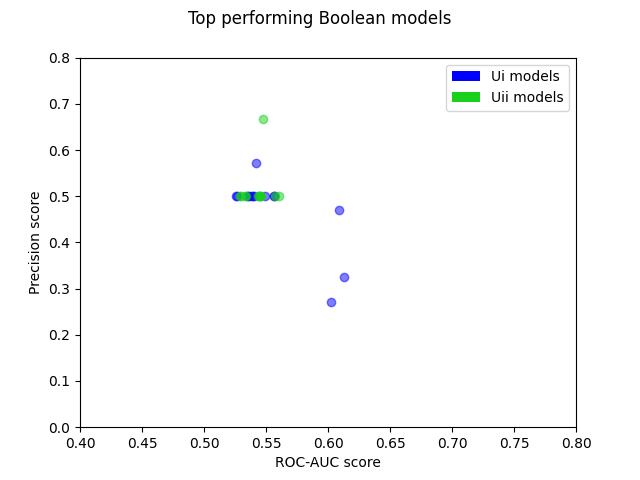

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


fig = plt.figure()
ax = fig.add_subplot(111)

x = [a[1]['roc-auc'] for a in ui_0_results]
y = [a[1]['precision'] for a in ui_0_results]
ax.scatter(x, y, c='blue', alpha=0.5)

x = [a[1]['roc-auc'] for a in uii_0_results]
y = [a[1]['precision'] for a in uii_0_results]
ax.scatter(x, y, c='#17d11d', alpha=0.5)

classes = ['Ui models','Uii models']
class_colours = ['blue','#17d11d']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
ax.legend(recs,classes,loc=1)

ax.set_xlim([0.4,0.8])
ax.set_ylim([0,0.8])
plt.ylabel("Precision score")
plt.xlabel("ROC-AUC score")


plt.suptitle("Top performing Boolean models")
plt.show()